In [1]:
import tensorflow as tf
import os
import numpy as np
import random
SEED = 0
#------------------------------------------------------------------------------------
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
#------------------------------------------------------------------------------------
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)
#-----------------------------------------------------------------------------------

In [2]:
%matplotlib notebook
import pandas as pd
from data_extraction import *
from resp_signal_extraction import *
from rr_extration import *
from sklearn.preprocessing import MinMaxScaler
import re
import pickle as pkl
from tf_model import *
from tf_model_new import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
from filters import *
import tqdm
import plotly as py
import plotly.figure_factory as ff
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
py.offline.init_notebook_mode(connected = True)
from plotly import tools
import plotly.express as px

In [3]:
input_conf = 'conff'

In [4]:
with open('output','rb') as f:
    output_data = pkl.load(f)

with open('input','rb') as f:
    input_data = pkl.load(f)

with open('raw_signal.pkl','rb') as f:
    raw_data = pkl.load(f)

input_data = np.transpose(input_data, (0,2,1))
raw_data = np.transpose(raw_data, (0,2,1))
annotation = pd.read_pickle('/media/acrophase/pose1/charan/BR_Uncertainty/MONTE_CARLO/annotation.pkl')
reference_rr = (annotation['Reference_RR'].values).reshape(-1,1)

input_data = np.around(input_data , decimals = 4)
raw_data = np.around(raw_data , decimals = 4)
output_data = np.around(output_data , decimals = 4)
reference_rr = np.around(reference_rr , decimals = 4)

tensor_input = tf.convert_to_tensor(input_data, dtype = 'float32')
tensor_output = tf.convert_to_tensor(output_data, dtype = 'float32')
tensor_ref_rr = tf.convert_to_tensor(reference_rr, dtype = 'float32')
tensor_raw_data = tf.convert_to_tensor(raw_data, dtype = 'float32')
training_ids = annotation['patient_id'] < 13

x_train_data = tensor_input[tf.convert_to_tensor(training_ids.values)]
x_test_data = tensor_input[tf.convert_to_tensor(~(training_ids.values))]
x_train_ref_rr = tensor_ref_rr[tf.convert_to_tensor(training_ids.values)]
x_test_ref_rr = tensor_ref_rr[tf.convert_to_tensor(~(training_ids.values))]
x_train_raw_sig = tensor_raw_data[tf.convert_to_tensor(training_ids.values)]
x_test_raw_sig = tensor_raw_data[tf.convert_to_tensor(~(training_ids.values))]

y_train_data = tensor_output[tf.convert_to_tensor(training_ids.values)]
y_test_data = tensor_output[tf.convert_to_tensor(~(training_ids.values))]

2021-10-28 14:21:19.615265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:21:19.620402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:21:19.620730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-28 14:21:19.650330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
if input_conf == 'confc':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confb':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confd':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)
if input_conf == 'confa':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

if input_conf == 'confe':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data))
        train_dataset = train_dataset.shuffle(len(x_train_raw_sig)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data))
        test_dataset = test_dataset.batch(128)
if input_conf == 'conff':
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw_sig , y_train_data, x_train_ref_rr))
        train_dataset = train_dataset.shuffle(len(x_train_data)).batch(128)
        test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw_sig , y_test_data, x_test_ref_rr))
        test_dataset = test_dataset.batch(128)

In [6]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confc/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confd/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)
            
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confb/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confe/best_model_20.001_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
        
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/confa/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
        test_loss_list.append(test_loss)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODEL_WO_ATT/conff/best_model_10.0001_1e-05_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
        test_loss_list.append(test_loss)

2021-10-28 14:21:20.973329: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


In [7]:
def extremas_extraction(signal):
    avg_breath_duration = np.array([])
    extrema_relevent = []
    for item in signal:
        amplitude = np.array([])
        pos_peaks , _ = scipy.signal.find_peaks(item , height = [-3000,3000])
        neg_peaks , _ = scipy.signal.find_peaks(-1*item , height = [-3000 , 3000])
        extremas = np.concatenate((pos_peaks , neg_peaks))
        extremas = np.sort(extremas)
        for i in range(len(extremas)):
            amplitude = np.append(amplitude , item[int(extremas[i])])
        amplitude_diff = np.abs(np.diff(amplitude))
        q3 = np.percentile(amplitude_diff , 75)
        threshold = 0.3*q3
        eliminate_pairs_of_extrema = 1
        while(eliminate_pairs_of_extrema):
            amps = np.array([])
            if len(extremas)<3:
                eliminate_pairs_of_extrema = 0
                continue
            for i in range(len(extremas)):
                amps = np.append(amps , item[int(extremas[i])])
            amp_diff = np.abs(np.diff(amps)) 
            min_amp_diff , index = min(amp_diff) , np.argmin(amp_diff)
            #print(min_amp_diff)
            if min_amp_diff > threshold:
                eliminate_pairs_of_extrema = 0
                #extrema_relevent = extremas
            else:
                extremas = np.concatenate((extremas[0:index] , extremas[index+2 :]))
                #amplitude_diff = np.delete(amplitude_diff , index)
        if item[int(extremas[0])] < item[int(extremas[1])]:
            extremas = extremas[1:]
        if item[int(extremas[-1])] < item[int(extremas[-2])]:
            extremas = extremas[:-1]
        no_of_breaths = (len(extremas)-1)/2
        breath_duration = extremas[-1] - extremas[0]
        avg_breath_duration = np.append(avg_breath_duration , breath_duration/no_of_breaths)
        extrema_relevent.append(extremas)
    return avg_breath_duration , extrema_relevent

In [8]:
ref_sig = y_test_data.numpy()
fbpB , fbpA = band_pass(0.1,0.7,8)
final_ref_resp_sig = []
for item in ref_sig:
    final_ref_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
final_ref_resp_sig = np.array(final_ref_resp_sig)

In [9]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confb':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))

In [10]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

In [11]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

Mean Absolute Error average wise for conff is: 2.4701128087778494
Root Mean Square Error average wise for conff is: 3.0890775476876513
Mean Absolute Error instantaneous wise for conff is: 4.216654221536459
Root Mean Square Error instantaneous wise for conff is: 5.107986262115747


# WITH ATTENTION BLOCK

In [12]:
if input_conf == 'confc':
    model_input_shape = (128,3)
    model  = BRUnet_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confc/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4,at_5 = model(x_batch_test)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
        test_loss_list.append(test_loss)
        
#-----------------------------------------------------------------------------------------------------------------
if input_conf == 'confd':
    model_input_shape = (128,3)
    model  = BRUnet_Multi_resp_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confd/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    attn8 = tf.convert_to_tensor([])
    attn9 = tf.convert_to_tensor([])
    for step , (x_batch_test,y_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9 = model(x_batch_test)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
            attn8 = at_8
            attn9 = at_9
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
            attn8 = tf.concat([attn8 , at_8] , axis = 0)
            attn9 = tf.concat([attn9 , at_9] , axis = 0)
        test_loss_list.append(test_loss)
            
#------------------------------------------------------------------------------------------------------------------
if input_conf == 'confb':
    model_input_shape = (128,3)
    model  = BRUnet_Encoder_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,128,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confb/best_model_0.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    for step , (x_batch_test,x_batch_test_ref_rr) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4 = model(x_batch_test)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
        test_loss_list.append(test_loss)
#--------------------------------------------------------------------------------------------------------------------
if input_conf == 'confe':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confe/best_model_10.001_0.0001_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw,y_batch_test) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4,at_5,at_6,at_7 = model(x_batch_test_raw)
        test_loss = loss_fn(y_batch_test , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
        test_loss_list.append(test_loss)
        
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'confa':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_encoder_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/confa/best_model_10.01_1e-05_100.h5')
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw, x_batch_test_ref_rr) in enumerate(test_dataset):
        output,at_1,at_2,at_3,at_4  = model(x_batch_test_raw)
        test_loss = loss_fn(x_batch_test_ref_rr , output)
        if step == 0:
            final_output = output
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
        else:
            final_output = tf.concat([final_output , output] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
        test_loss_list.append(test_loss)
#-------------------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    model_input_shape = (2048,3)
    model  = BRUnet_raw_multi_ATT(model_input_shape)
    loss_fn = Huber()
    model(tf.ones((128,2048,3)))
    model.load_weights('/media/acrophase/pose1/charan/BR_Uncertainty/ATTENTION/SAVED_MODELS_WITH_ATT/conff/best_model_1e-04_1e-05_100.h5')        
    test_loss_list = []
    final_output = tf.convert_to_tensor([])
    final_output_rr = tf.convert_to_tensor([])
    attn1 = tf.convert_to_tensor([])
    attn2 = tf.convert_to_tensor([])
    attn3 = tf.convert_to_tensor([])
    attn4 = tf.convert_to_tensor([])
    attn5 = tf.convert_to_tensor([])
    attn6 = tf.convert_to_tensor([])
    attn7 = tf.convert_to_tensor([])
    attn8 = tf.convert_to_tensor([])
    attn9 = tf.convert_to_tensor([])
    attn10 = tf.convert_to_tensor([])
    attn11 = tf.convert_to_tensor([])
    for step , (x_batch_test_raw , y_batch_test , x_batch_test_ref_rr) in enumerate(test_dataset):
        test_output,test_out_rr,at_1,at_2,at_3,at_4,at_5,at_6,at_7,at_8,at_9,at_10,at_11 = model(x_batch_test_raw)
        test_loss_resp = loss_fn(y_batch_test  , test_output)
        test_loss_rr = loss_fn(x_batch_test_ref_rr , test_out_rr)
        test_loss = test_loss_resp + test_loss_rr
        if step == 0:
            final_output = test_output
            final_output_rr = test_out_rr
            attn1 = at_1
            attn2 = at_2
            attn3 = at_3
            attn4 = at_4
            attn5 = at_5
            attn6 = at_6
            attn7 = at_7
            attn8 = at_8
            attn9 = at_9
            attn10 = at_10
            attn11 = at_11
        else:
            final_output = tf.concat([final_output , test_output] , axis = 0)
            final_output_rr = tf.concat([final_output_rr , test_out_rr] , axis = 0)
            attn1 = tf.concat([attn1 , at_1] , axis = 0)
            attn2 = tf.concat([attn2 , at_2] , axis = 0)
            attn3 = tf.concat([attn3 , at_3] , axis = 0)
            attn4 = tf.concat([attn4 , at_4] , axis = 0)
            attn5 = tf.concat([attn5 , at_5] , axis = 0)
            attn6 = tf.concat([attn6 , at_6] , axis = 0)
            attn7 = tf.concat([attn7 , at_7] , axis = 0)
            attn8 = tf.concat([attn8 , at_8] , axis = 0)
            attn9 = tf.concat([attn9 , at_9] , axis = 0)
            attn10 = tf.concat([attn10 , at_10] , axis = 0)
            attn11 = tf.concat([attn11 , at_11] , axis = 0)
        test_loss_list.append(test_loss)

In [13]:
if input_conf == 'confa':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))
#----------------------------------------------------------------------------------------------------------------   
if input_conf == 'confb':
    final_output_rr = final_output.numpy()
    final_output_rr = final_output_rr.reshape(final_output_rr.shape[0],final_output_rr.shape[1])
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    error = np.abs(avg_ref_breath - final_output_rr)
    mae = np.mean(error)
    rmse = np.sqrt(np.mean(error**2))
    print('Mean Absolute Error for {} is: {}'.format(input_conf,mae))
    print('Root Mean Square Error for {} is: {}'.format(input_conf,rmse))

In [14]:
if input_conf == 'confc':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    

    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#--------------------------------------------------------------------------------------------------------------------    
if input_conf == 'confe':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    final_output_resp = final_output.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_breaths = (60*4/duration_resp).reshape(-1,1)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - avg_breaths)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

In [15]:
if input_conf == 'confd':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

#-------------------------------------------------------------------------------------------------------
if input_conf == 'conff':
    final_output_resp_sig = []
    inst_br_dur = []
    inst_ref_br_dur = []
    inst_rr = []
    inst_ref_rr = []
    
    final_output_resp = final_output.numpy()
    final_rr = final_output_rr.numpy()
    final_output_resp = final_output_resp.reshape(final_output_resp.shape[0],final_output_resp.shape[1])
    final_rr = final_rr.reshape(final_rr.shape[0],final_rr.shape[1])
    for item in final_output_resp:
        final_output_resp_sig.append(scipy.signal.filtfilt(fbpB,fbpA , item))
        
    final_output_resp_sig = np.array(final_output_resp_sig)
    duration_resp,extremas_resp = extremas_extraction(final_output_resp_sig)
    duration_ref_resp,extremas_ref_resp = extremas_extraction(final_ref_resp_sig)
    avg_ref_breath = (60*4/duration_ref_resp).reshape(-1,1)
    
    error_avg_breaths = np.abs(avg_ref_breath - final_rr)
    mae_avg_breath = np.mean(error_avg_breaths)
    rmse_avg_breath = np.sqrt(np.mean(error_avg_breaths**2))
    
    for item in extremas_resp:
        inst_br_dur.append(np.diff(item[0::2]))
    for item in extremas_ref_resp:
        inst_ref_br_dur.append(np.diff(item[0::2]))
    for item in inst_br_dur:
        inst_rr.append(np.mean(60*4/item))
    for item in inst_ref_br_dur:
        inst_ref_rr.append(np.mean(60*4/item))
    
    inst_rr = (np.array(inst_rr)).reshape(-1,1)
    inst_ref_rr = (np.array(inst_ref_rr)).reshape(-1,1)
    
    error_inst_breaths = np.abs(inst_ref_rr - inst_rr)
    mae_inst_breath = np.mean(error_inst_breaths)
    rmse_inst_breath = np.sqrt(np.mean(error_inst_breaths**2))
    
    print('Mean Absolute Error average wise for {} is: {}'.format(input_conf,mae_avg_breath))
    print('Root Mean Square Error average wise for {} is: {}'.format(input_conf,rmse_avg_breath))
    
    print('Mean Absolute Error instantaneous wise for {} is: {}'.format(input_conf,mae_inst_breath))
    print('Root Mean Square Error instantaneous wise for {} is: {}'.format(input_conf,rmse_inst_breath))

Mean Absolute Error average wise for conff is: 2.4339144865854654
Root Mean Square Error average wise for conff is: 3.0313691618094833
Mean Absolute Error instantaneous wise for conff is: 3.180975017034846
Root Mean Square Error instantaneous wise for conff is: 4.032288125541829


In [16]:
print(attn1.shape)
print(attn2.shape)
print(attn3.shape)
print(attn4.shape)
print(attn5.shape)
print(attn6.shape)
print(attn7.shape)
print(attn8.shape)
print(attn9.shape)

(814, 64, 512)
(814, 32, 512)
(814, 16, 512)
(814, 8, 512)
(814, 32, 512)
(814, 64, 512)
(814, 128, 256)
(814, 128, 256)
(814, 128, 256)


<IPython.core.display.Javascript object>


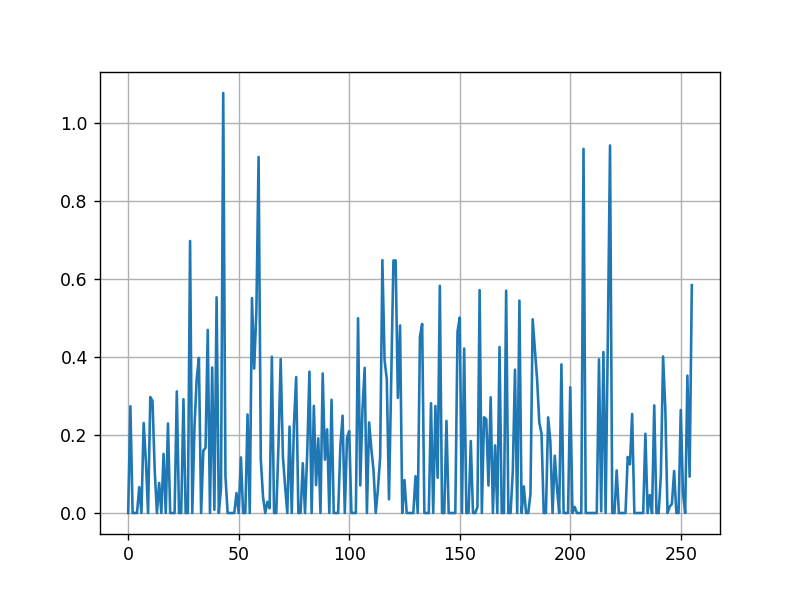

In [17]:
x = attn8[0].numpy()
#y = np.transpose(x)
plt.figure(3)
plt.plot(x[0])
plt.grid(True)
plt.show()


In [18]:
attn9[0].shape

TensorShape([128, 256])